In [332]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from category_encoders.wrapper import PolynomialWrapper
from sklearn.decomposition import PCA

#### Reading dataset.csv

In [333]:
df = pd.read_csv('./data/dataset.csv', low_memory=False)
df.rename(columns={'Unnamed: 0': 'index'}, inplace=True)
df.rename(columns = {'country': 'circuit_country'}, inplace = True)
df.drop(columns=['index'], inplace=True)
df.columns

Index(['raceId', 'year', 'round', 'circuitId', 'name', 'date', 'time',
       'circuit_id', 'weather_warm', 'weather_cold', 'weather_dry',
       'weather_wet', 'weather_cloudy', 'resultId', 'driverId',
       'constructorId', 'car_number', 'grid', 'results_positionOrder',
       'results_points', 'laps', 'milliseconds', 'fastestLap',
       'fastestLapTime', 'fastestLapSpeed', 'statusId', 'status',
       'circuit_location', 'circuit_country', 'constructorStandingsId',
       'constructor_points', 'constructor_position', 'constructor_wins',
       'constructorRef', 'constructor_nationality', 'driverRef',
       'driver_number', 'driver_code', 'forename', 'dob', 'driver_nationality',
       'driverStandingsId', 'driver_points', 'driver_position', 'driver_wins',
       'qualifyId', 'number', 'qualifying_position', 'q1_time', 'q2_time',
       'q3_time', 'no_of_stops', 'ms_avg', 'first_5_avg_time',
       'last_10_avg_time', 'lap_position_after_5',
       'lap_position_before_last_10'],


#### Dropping the columns

In [334]:
cols_to_be_dropped = ['round', 'name', 'time', 'circuit_id', 'car_number', 'resultId', 'driverRef', 'results_points', 'laps', 'fastestLap', 'fastestLapTime', 'fastestLapSpeed', 'first_5_avg_time', 'last_10_avg_time', 'lap_position_after_5', 'lap_position_before_last_10', 'circuit_location', 'constructorStandingsId', 'constructorRef', 'constructor_points', 'driverRef', 'driver_number', 'driver_code', 'forename', 'driverStandingsId', 'driver_points', 'number', 'status', 'qualifying_position', 'q1_time', 'q2_time', 'q3_time', 'ms_avg', 'no_of_stops', 'driver_position', 'qualifyId']
df_after_dropping = df.drop(columns = cols_to_be_dropped)

#### Getting age from date & dob

In [335]:
from datetime import datetime
from dateutil import relativedelta

# get two dates
race_date = df_after_dropping['date']
driver_dob = df_after_dropping['dob']

ages = []

for i in range(len(race_date)):
    start_date = datetime.strptime(race_date[i],"%Y-%m-%d")
    end_date = datetime.strptime(driver_dob[i], "%Y-%m-%d")
    delta = relativedelta.relativedelta(start_date, end_date)
    ages.append(delta.years)

df_after_dropping['driver_age'] = ages
df_after_dropping.drop(columns = ['date', 'dob'], inplace = True)
df_after_dropping

,raceId,year,circuitId,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,driverId,constructorId,...,results_positionOrder,milliseconds,statusId,circuit_country,constructor_position,constructor_wins,constructor_nationality,driver_nationality,driver_wins,driver_age
0,1,2009,1,1.0,0.0,0.0,0.0,0.0,18,23,...,1,5655784,1,Australia,1.0,1.0,British,British,1.0,29
1,90,2004,1,0.0,0.0,1.0,0.0,0.0,18,16,...,6,5126355,1,Australia,4.0,0.0,British,British,0.0,24
2,108,2003,1,1.0,0.0,1.0,1.0,0.0,18,16,...,10,5748074,1,Australia,6.0,0.0,British,British,0.0,23
3,338,2010,1,0.0,0.0,0.0,1.0,1.0,18,1,...,1,5616531,1,Australia,2.0,1.0,British,British,1.0,30
4,841,2011,1,0.0,0.0,0.0,0.0,0.0,18,1,...,6,5424563,1,Australia,2.0,0.0,British,British,0.0,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25655,815,1953,66,0.0,0.0,1.0,0.0,0.0,720,6,...,8,\N,111,Switzerland,NaN,NaN,Italian,Swiss,0.0,34
25656,817,1952,66,1.0,0.0,0.0,0.0,0.0,720,141,...,21,\N,121,Switzerland,NaN,NaN,French,Swiss,0.0,33
25657,815,1953,66,0.0,0.0,1.0,0.0,0.0,719,133,...,9,\N,116,Switzerland,NaN,NaN,British,Swiss,0.0,45
25658,832,1951,67,0.0,0.0,1.0,0.0,0.0,783,154,...,16,\N,5,Spain,NaN,NaN,French,French,0.0,46


#### Changing status IDs to 0s and 1s

In [336]:
df_after_dropping['statusId'][df_after_dropping['statusId'] > 1] = 0

C:\Users\nipun\AppData\Local\Temp\ipykernel_3916\639805009.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Replace Nan in Constructor_position by max Value = 21 & Replace Nan in Constructor_wins by 0

In [337]:
df_after_dropping['constructor_position'] = df_after_dropping['constructor_position'].fillna(21)
df_after_dropping['constructor_wins'] = df_after_dropping['driver_wins'].fillna(0)

## Analysis Graphs

In [338]:
# Drivers by nationality
nationality_driver = df_after_dropping.groupby(['driver_nationality'])['driver_nationality'].count().sort_values(ascending = False).reset_index(name = 'number_of_drivers')
nationality_driver['driver_nationality'][nationality_driver['number_of_drivers'] < 200] = 'Other'
nationality_driver = nationality_driver.groupby(['driver_nationality']).sum().reset_index()

fig = go.Figure(data=go.Pie(labels = nationality_driver['driver_nationality'], values=nationality_driver.number_of_drivers))
fig.update_layout(title = 'Drivers by Nationality')
fig.show()


C:\Users\nipun\AppData\Local\Temp\ipykernel_3916\1005006657.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [339]:
# Champions by nationality
champions = df_after_dropping[df_after_dropping['results_positionOrder'] == 1]
champions = champions.groupby(['driver_nationality'])['driver_nationality'].count().sort_values(ascending = False).reset_index(name = 'number_of_drivers')

fig = go.Figure(data=go.Pie(labels = champions['driver_nationality'], values=champions.number_of_drivers))
fig.update_layout(title = 'Champions by Driver Nationality')
fig.show()

In [340]:
# Completion rate by circuit
status_on_circuits = df_after_dropping[['circuitId', 'statusId']].groupby(['circuitId']).mean()
fig = px.bar(status_on_circuits, y = 'statusId')
fig.update_layout(title = 'Completion rate by circuit')
fig.show()

In [341]:
len(df_after_dropping.columns)

21

In [342]:
winners = df_after_dropping[['driverId', 'results_positionOrder', 'driver_age']][df_after_dropping['results_positionOrder'] == 1]
winners.drop(columns = ['driverId'], inplace=True)
winners_by_age = winners.groupby(['driver_age']).sum()
fig = px.bar(winners_by_age)
fig.update_layout(title = 'No. of races won by age')
fig.show()

In [343]:
wins = df_after_dropping[['grid', 'results_positionOrder']][df_after_dropping['results_positionOrder'] == 1]
wins = wins.groupby(['grid']).count()

fig = px.bar(wins)
fig.update_layout(title = 'No. of races won by grid position')
fig.show()

In [344]:
df_after_dropping.columns

Index(['raceId', 'year', 'circuitId', 'weather_warm', 'weather_cold',
       'weather_dry', 'weather_wet', 'weather_cloudy', 'driverId',
       'constructorId', 'grid', 'results_positionOrder', 'milliseconds',
       'statusId', 'circuit_country', 'constructor_position',
       'constructor_wins', 'constructor_nationality', 'driver_nationality',
       'driver_wins', 'driver_age'],
      dtype='object')

In [345]:
temp = df_after_dropping['milliseconds']

In [346]:
temp.isnull().sum()

0

In [347]:
temp.value_counts()

\N          18697
14259460        5
10928200        3
13929950        2
14203090        2
            ...  
5790883         1
5573886         1
5468011         1
5615997         1
14598070        1
Name: milliseconds, Length: 6927, dtype: int64

In [348]:
df_after_dropping[df_after_dropping['milliseconds'] == '\\N'][df_after_dropping['statusId'] == 1].index

C:\Users\nipun\AppData\Local\Temp\ipykernel_3916\2860193466.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



Int64Index([19871, 21594], dtype='int64')

In [349]:
df_after_dropping.drop(df_after_dropping[df_after_dropping['milliseconds'] == '\\N'][df_after_dropping['statusId'] == 1].index, inplace=True)

C:\Users\nipun\AppData\Local\Temp\ipykernel_3916\1646513684.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [350]:
df_after_dropping['weather_warm'] = df_after_dropping['weather_warm'].fillna(0)
df_after_dropping['weather_cold'] = df_after_dropping['weather_cold'].fillna(0)
df_after_dropping['weather_dry'] = df_after_dropping['weather_dry'].fillna(0)
df_after_dropping['weather_wet'] = df_after_dropping['weather_wet'].fillna(0)
df_after_dropping['weather_cloudy'] = df_after_dropping['weather_cloudy'].fillna(0)
df_after_dropping['driver_wins'] = df_after_dropping['driver_wins'].fillna(0)
df_after_dropping.isnull().sum()

raceId                     0
year                       0
circuitId                  0
weather_warm               0
weather_cold               0
weather_dry                0
weather_wet                0
weather_cloudy             0
driverId                   0
constructorId              0
grid                       0
results_positionOrder      0
milliseconds               0
statusId                   0
circuit_country            0
constructor_position       0
constructor_wins           0
constructor_nationality    0
driver_nationality         0
driver_wins                0
driver_age                 0
dtype: int64

In [351]:
df_after_dropping['milliseconds'] = df_after_dropping['milliseconds'].replace('\\N', 0)

In [352]:
df_after_dropping['milliseconds'] = df_after_dropping['milliseconds'].astype('int64')

In [353]:
df_after_dropping['milliseconds'] = df_after_dropping['milliseconds'].replace(0, df_after_dropping['milliseconds'].max() * 2)

In [354]:
df_after_dropping['milliseconds'].describe()

count    2.565800e+04
mean     2.368013e+07
std      1.068807e+07
min      2.070710e+05
25%      8.103325e+06
50%      3.018108e+07
75%      3.018108e+07
max      3.018108e+07
Name: milliseconds, dtype: float64

In [355]:
df_after_dropping.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25658 entries, 0 to 25659
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   raceId                   25658 non-null  int64  
 1   year                     25658 non-null  int64  
 2   circuitId                25658 non-null  int64  
 3   weather_warm             25658 non-null  float64
 4   weather_cold             25658 non-null  float64
 5   weather_dry              25658 non-null  float64
 6   weather_wet              25658 non-null  float64
 7   weather_cloudy           25658 non-null  float64
 8   driverId                 25658 non-null  int64  
 9   constructorId            25658 non-null  int64  
 10  grid                     25658 non-null  int64  
 11  results_positionOrder    25658 non-null  int64  
 12  milliseconds             25658 non-null  int64  
 13  statusId                 25658 non-null  int64  
 14  circuit_country       

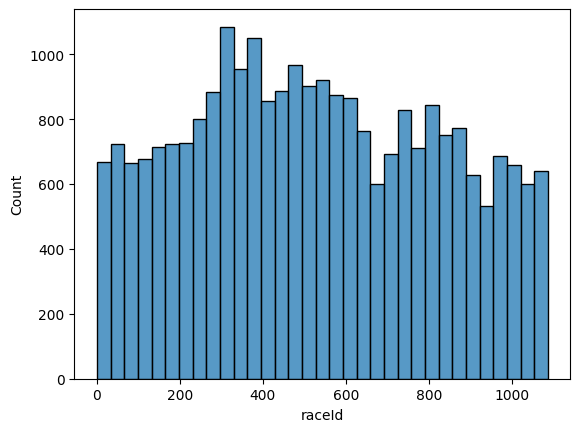

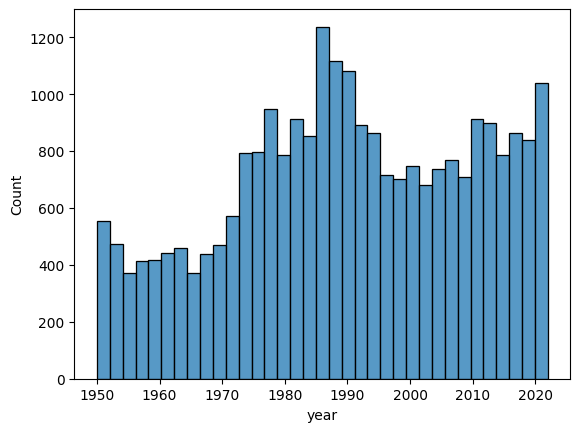

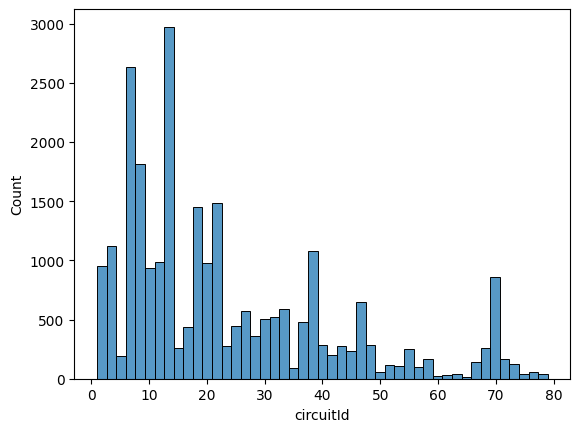

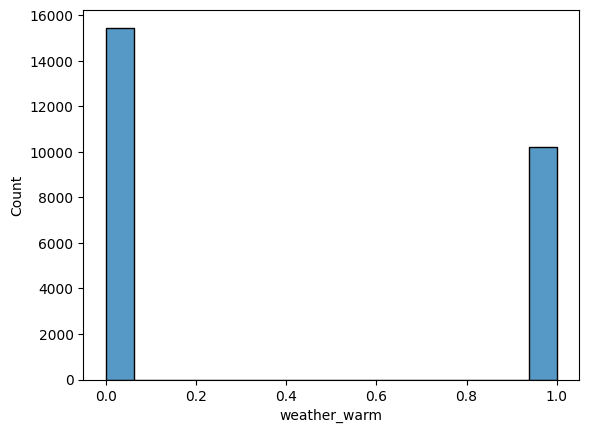

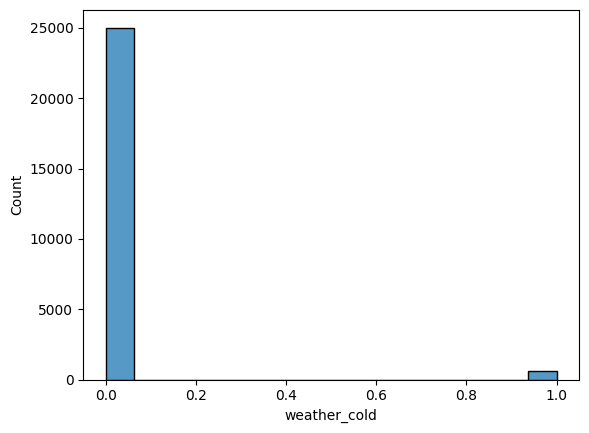

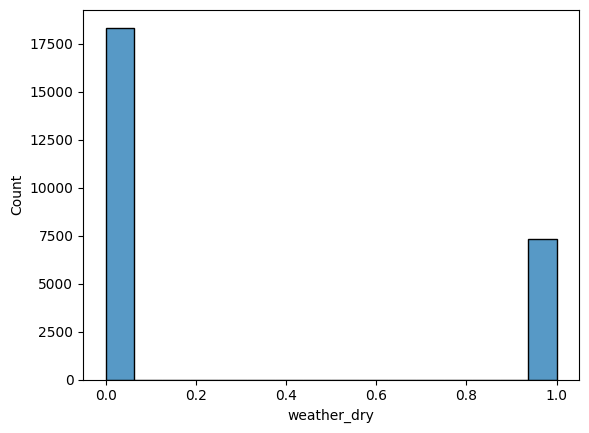

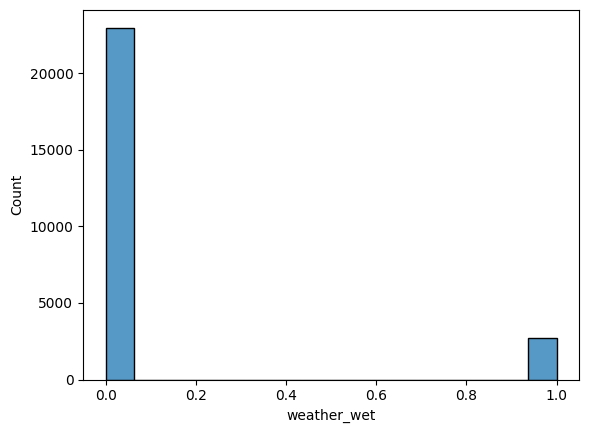

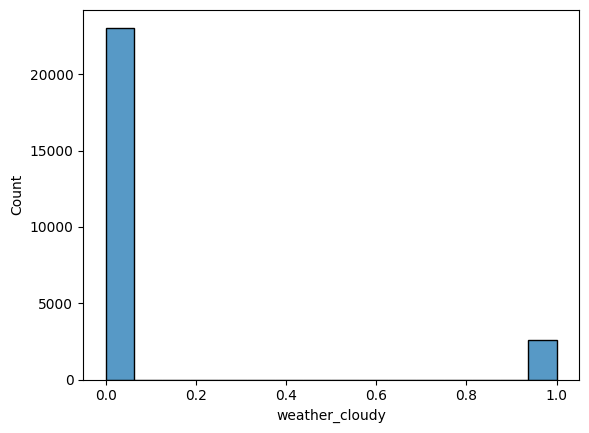

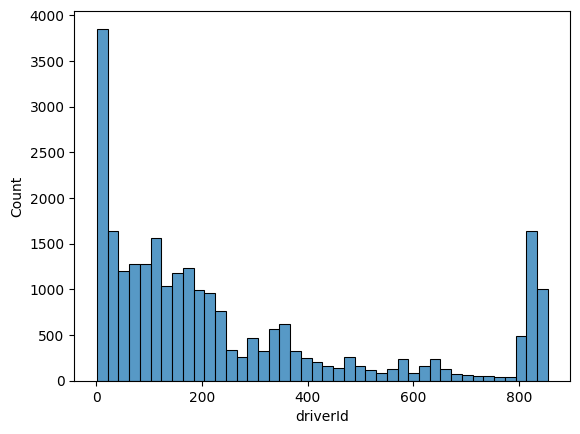

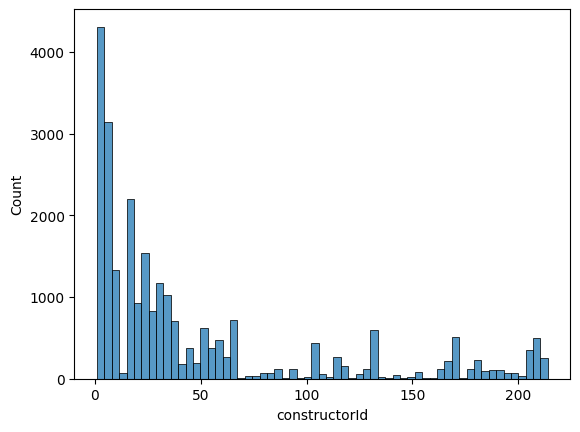

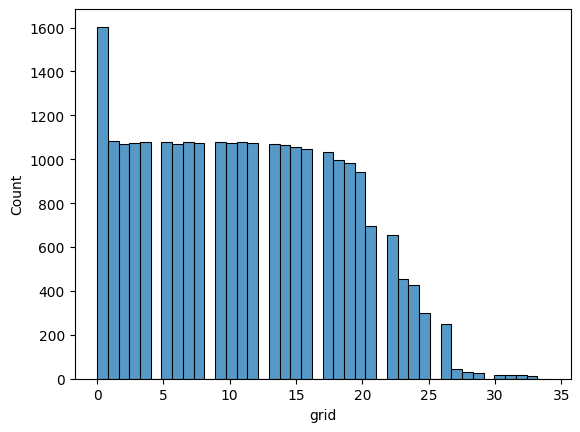

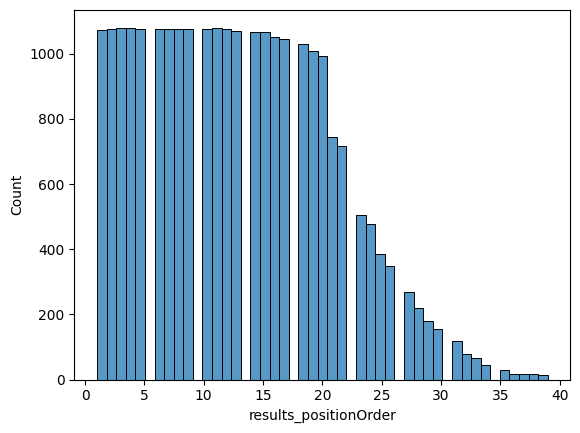

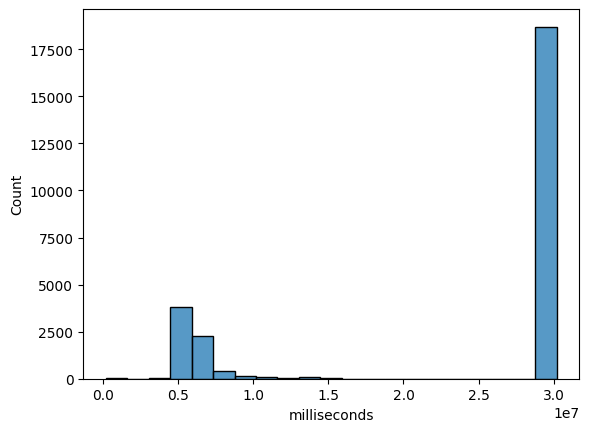

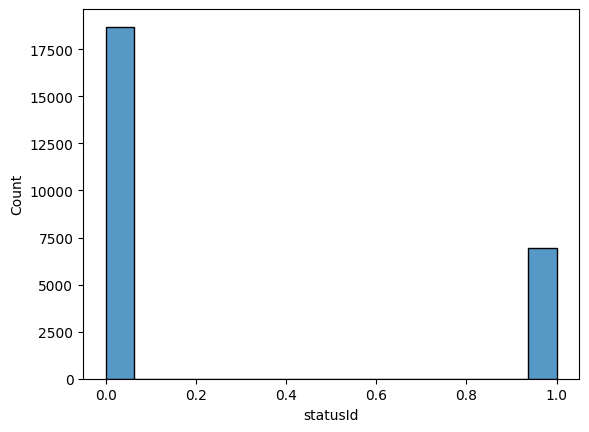

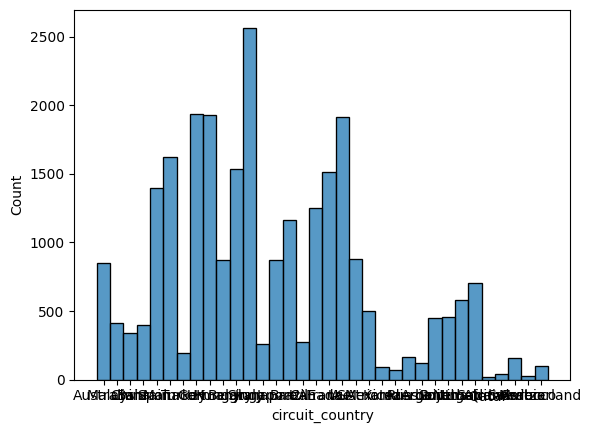

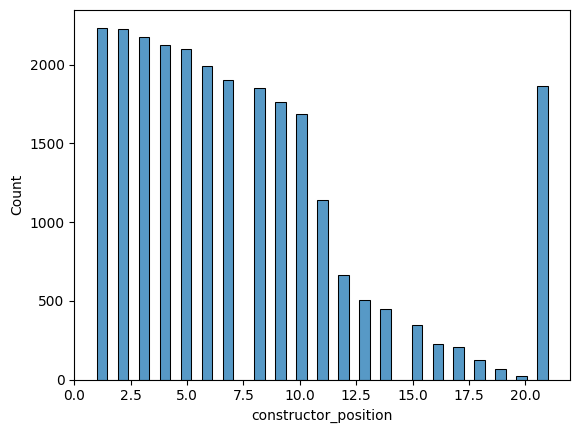

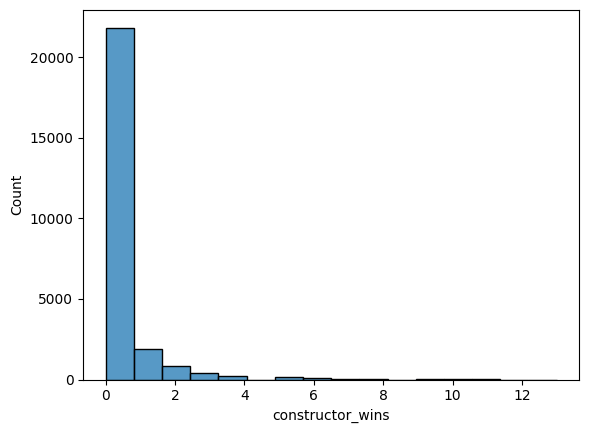

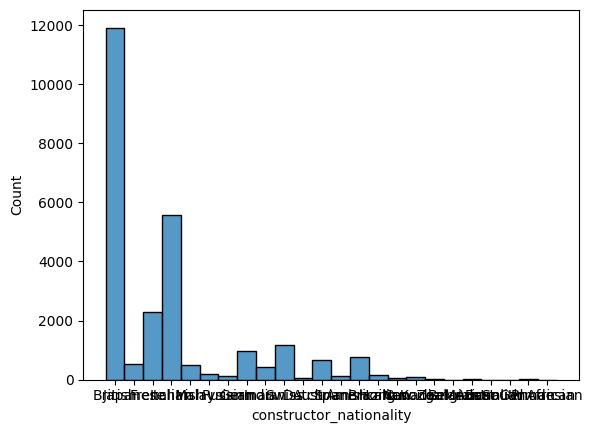

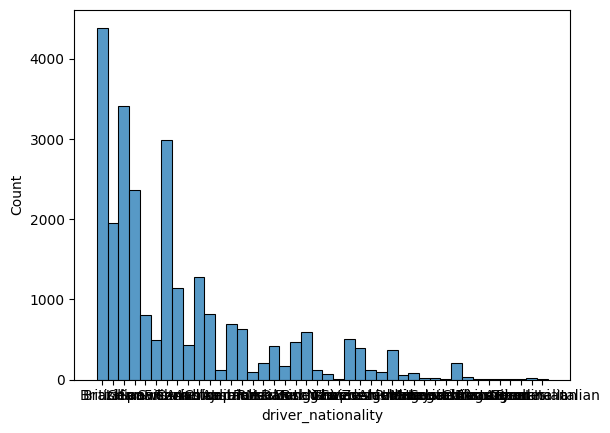

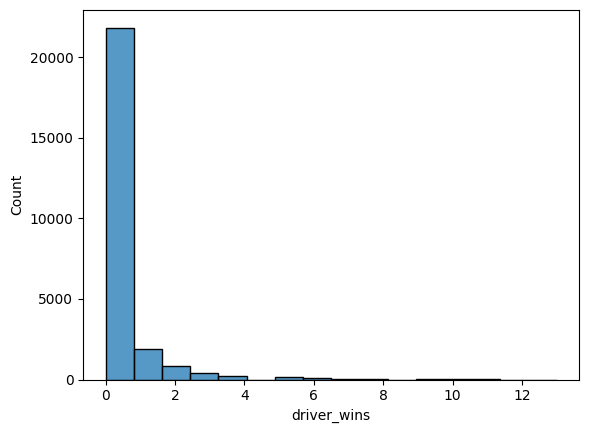

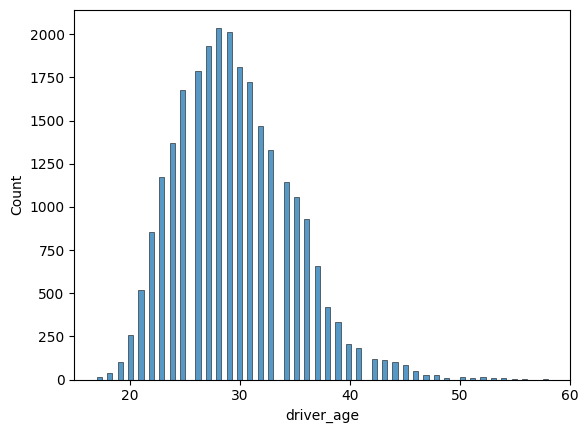

In [356]:
for i in df_after_dropping.columns: 
    sns.histplot(df_after_dropping[i])
    plt.show()

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



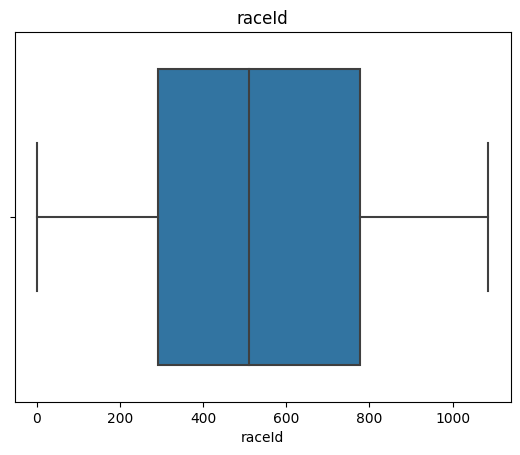

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



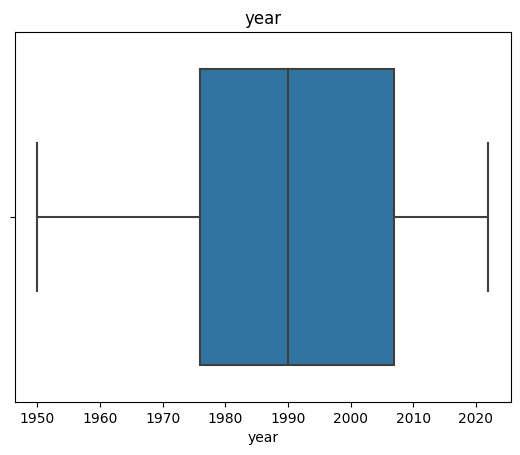

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



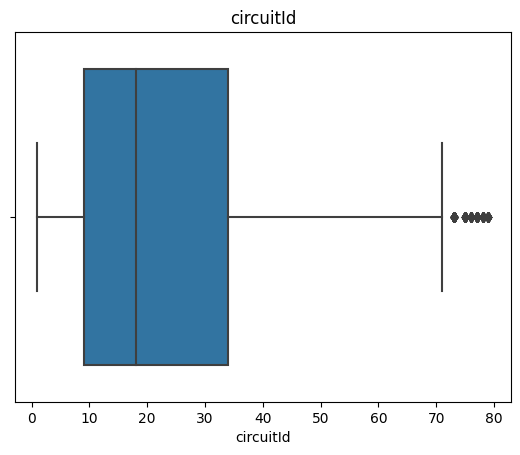

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



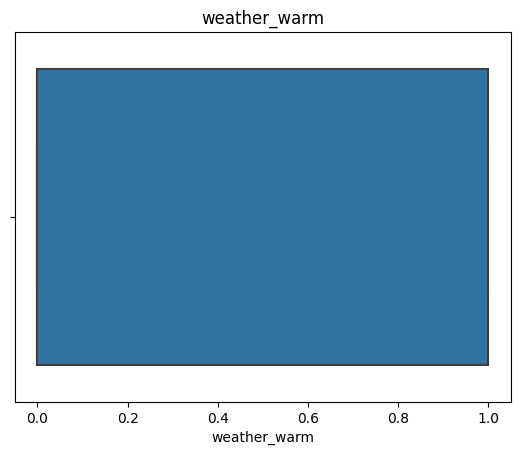

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



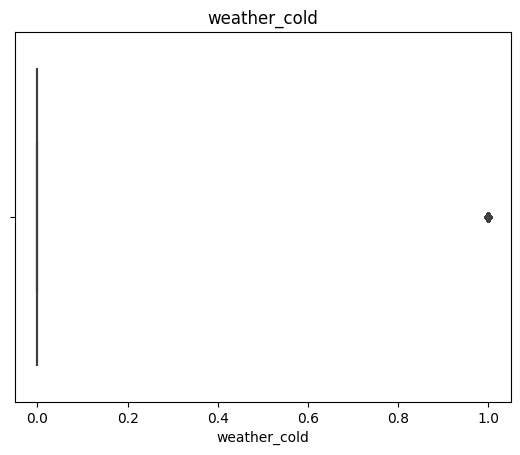

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



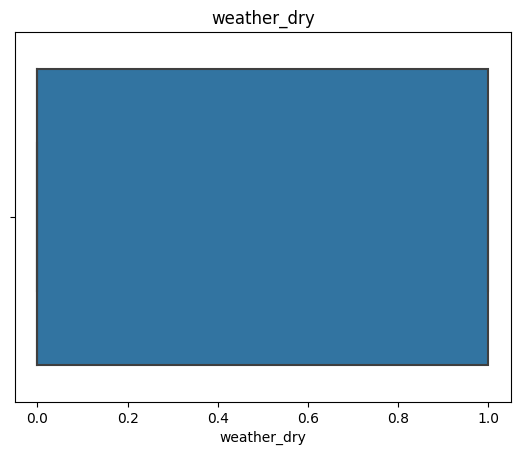

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



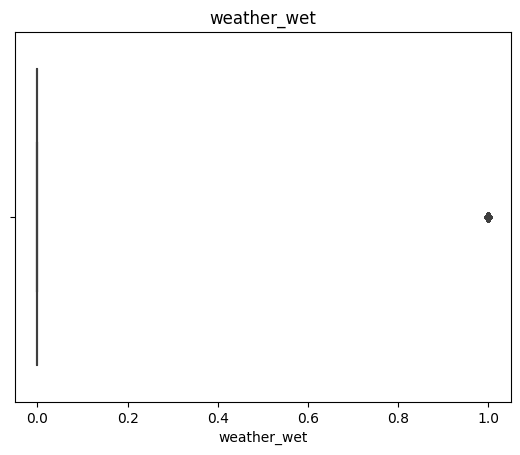

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



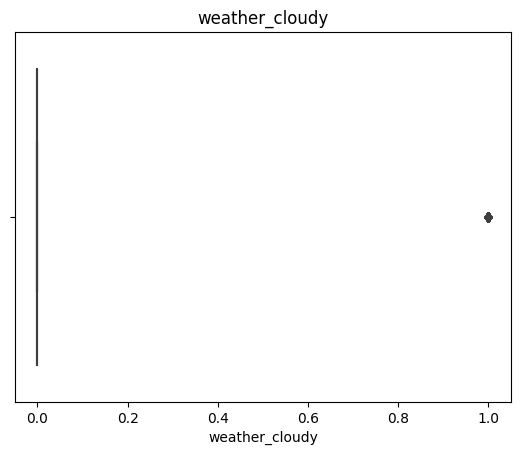

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



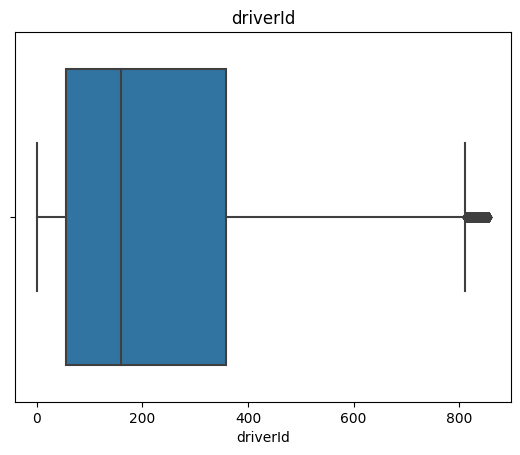

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



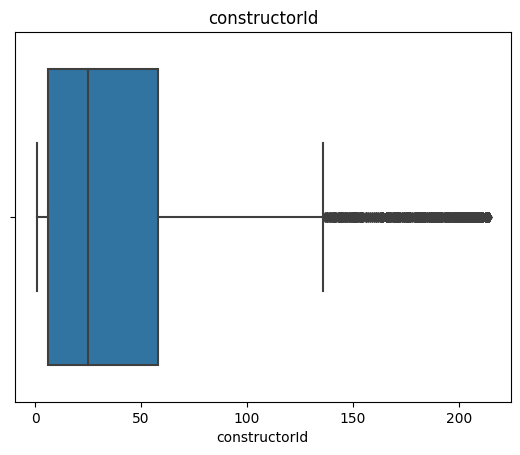

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



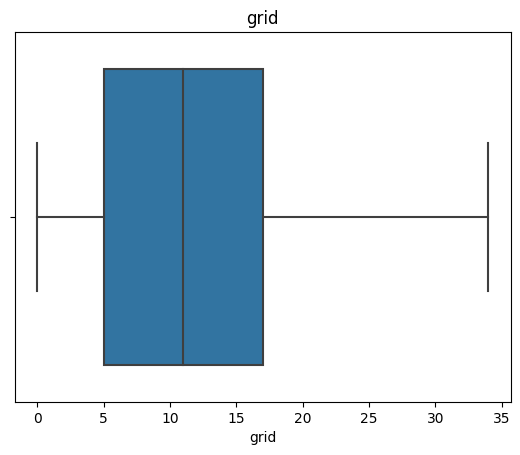

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



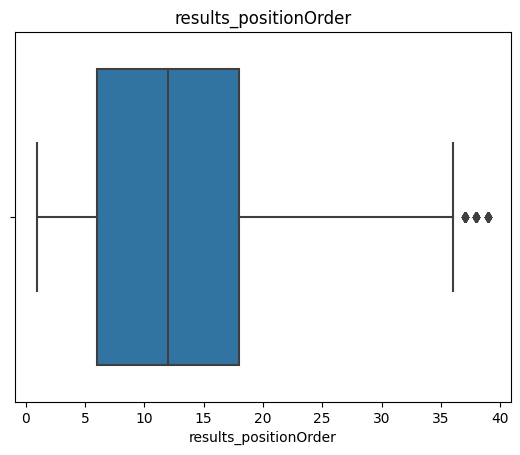

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



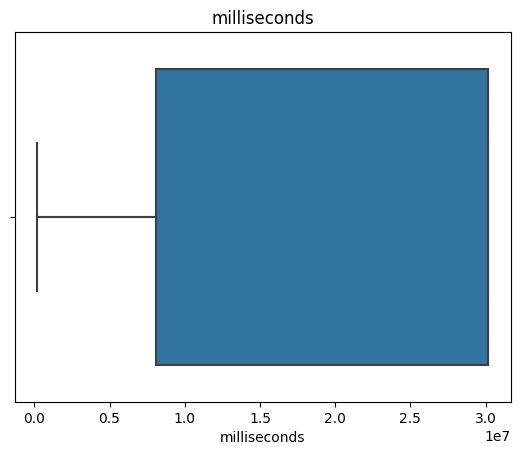

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



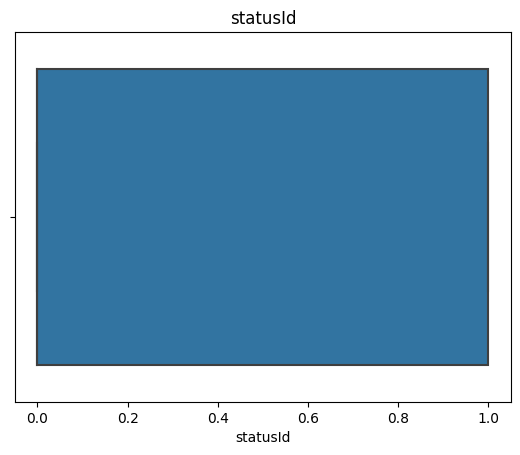

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



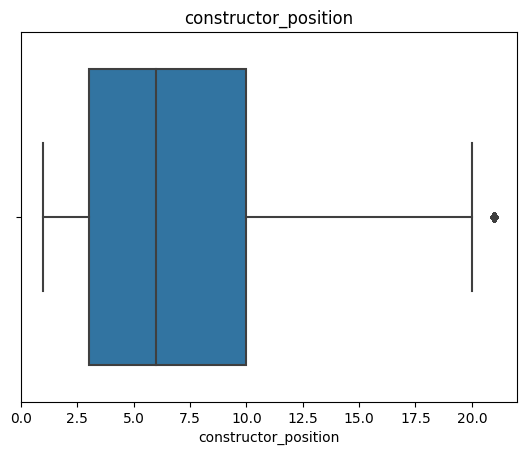

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



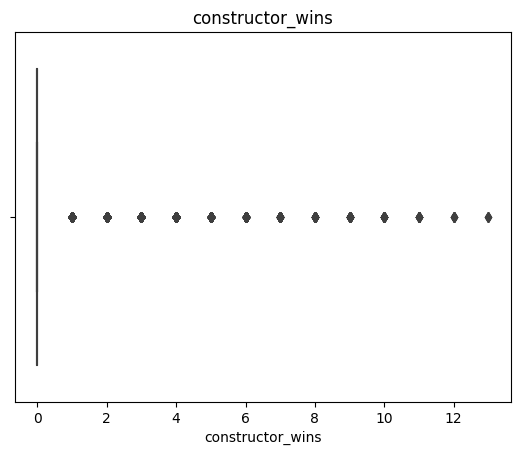

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



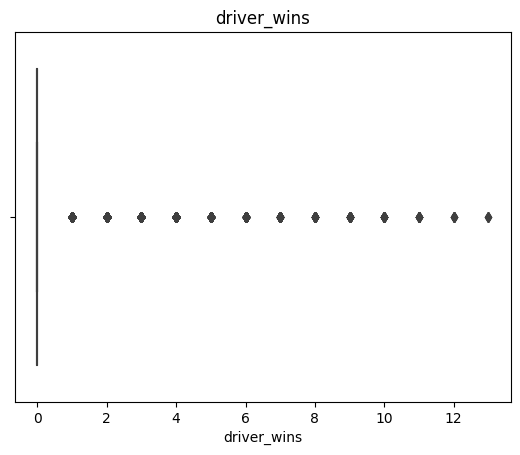

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



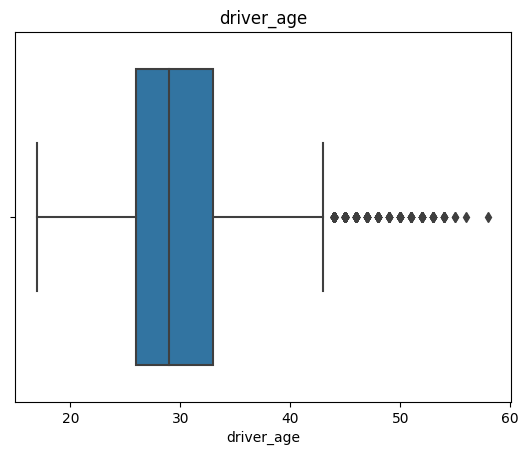

In [357]:
df_num = df_after_dropping.select_dtypes(include=[np.number])
for i in df_num.columns:
    sns.boxplot(df_num[i])
    plt.title(i)
    plt.show()

In [358]:
upper_limit = df_after_dropping["driver_age"].quantile(0.97)
df_after_dropping['driver_age'] = np.where(df_after_dropping['driver_age'] > upper_limit, upper_limit, df_after_dropping['driver_age'])

In [359]:
dictDriverCountry={'Argentine':1,'Australian':2,'Austrian':3,'Belgian':6,'Brazilian':7,'Canadian':8,'Chinese':9,
'French':10,'German':11,'Hungarian':12,'Indian':13,'Italian':14,'Japanese':15,'Malaysian':17,
'Mexican':18,'Monegasque':19,'Portuguese':22,'Russian':24,'South African':27,'Spanish':28,
'Swedish':29,'Swiss':30,'British':33,'American':34,'American-Italian':14,'Argentine-Italian':1,
'Chilean':35,'Colombian':36,'Czech':37,'Danish':38,'Dutch':39,'East German':11,'Finnish':40,'Indonesian':41,'Irish':42,
'Liechtensteiner':43,'New Zealander':44,'Polish':45,'Rhodesian':46,'Thai':47,'Uruguayan':48,'Venezuelan':49
}

In [360]:
dictCircuitCountry = {'Argentina': 1, 'Australia': 2, 'Austria': 3, 'Azerbaijan': 4, 'Bahrain': 5, 'Belgium': 6, 
'Brazil': 7, 'Canada': 8, 'China': 9, 'France': 10, 'Germany': 11, 'Hungary': 12, 'India': 13, 'Italy': 14, 'Japan': 15, 
'Korea': 16, 'Malaysia': 17, 'Mexico': 18, 'Monaco': 19, 'Morocco': 20, 'Netherlands': 21, 'Portugal': 22, 'Qatar': 23, 
'Russia': 24, 'Saudi Arabia': 25, 'Singapore': 26, 'South Africa': 27, 'Spain': 28, 'Sweden': 29, 'Switzerland': 30, 
'Turkey': 31, 'UAE': 32, 'UK': 33, 'USA': 34}

In [361]:
df_after_dropping['circuit_country'] = df_after_dropping['circuit_country'].map(dictCircuitCountry)

In [362]:
df_after_dropping['driver_nationality'] = df_after_dropping['driver_nationality'].map(dictDriverCountry)

<AxesSubplot:>

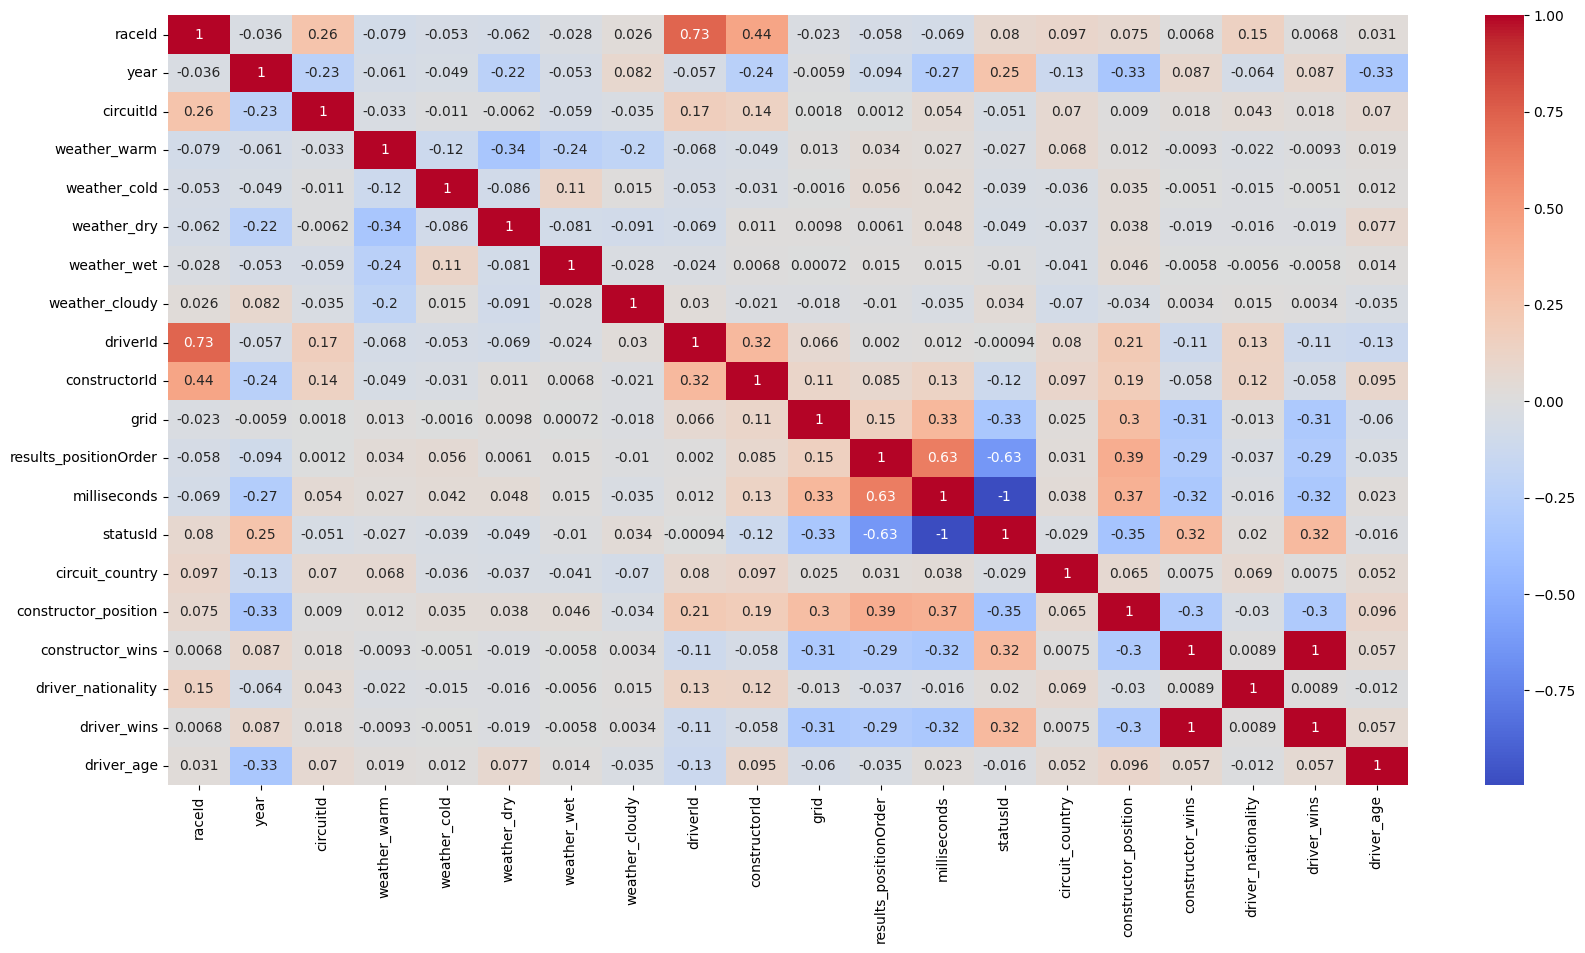

In [363]:
plt.figure(figsize=(20,10))
sns.heatmap(df_after_dropping.corr(), annot=True, cmap='coolwarm')

In [376]:
import random
# x_train, x_test, y_train, y_test = train_test_split(df_after_dropping.drop(columns = ['results_positionOrder']), df_after_dropping['results_positionOrder'], test_size = 0.15, random_state = 42, stratify=df_after_dropping['results_positionOrder'])
testing_years = []
r1 = random.sample(range(2010, 2021), 3)    
r2 = random.sample(range(1950, 1990), 3)
testing_years.extend(r1)
testing_years.extend(r2)

df_test = pd.DataFrame()
for i in testing_years:
    df_temp = df_after_dropping[df_after_dropping['year'] == i]
    df_test = pd.concat([df_test, df_temp])

df_train = pd.concat([df_after_dropping, df_test, df_test]).drop_duplicates(keep=False)

x_train, x_test, y_train, y_test = df_train.drop(columns = ['results_positionOrder']), df_test.drop(columns = ['results_positionOrder']), df_train['results_positionOrder'], df_test['results_positionOrder']
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(23788, 20) (1870, 20) (23788,) (1870,)


In [365]:
standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()

In [366]:
x_train['milliseconds'] = min_max_scaler.fit_transform(x_train[['milliseconds']])
x_test['milliseconds'] = min_max_scaler.transform(x_test[['milliseconds']])

In [367]:
x_train['driver_age'] = min_max_scaler.fit_transform(x_train[['driver_age']])
x_test['driver_age'] = min_max_scaler.transform(x_test[['driver_age']])

In [368]:
x_train['driver_wins'] = standard_scaler.fit_transform(x_train[['driver_wins']])
x_test['driver_wins'] = standard_scaler.transform(x_test[['driver_wins']])

In [369]:
x_train['constructor_wins'] = standard_scaler.fit_transform(x_train[['constructor_wins']])
x_test['constructor_wins'] = standard_scaler.transform(x_test[['constructor_wins']])

In [370]:
encoder = TargetEncoder(cols = ['constructor_nationality', 'driverId', 'constructorId', 'circuitId'], smoothing = 10, min_samples_leaf = 20)
# encoder = PolynomialWrapper(encoder_target)
x_train = encoder.fit_transform(x_train, y_train)
x_test = encoder.transform(x_test)

In [371]:
x_train['constructor_nationality'] = standard_scaler.fit_transform(x_train[['constructor_nationality']])
x_test['constructor_nationality'] = standard_scaler.transform(x_test[['constructor_nationality']])

In [372]:
x_train['driverId'] = standard_scaler.fit_transform(x_train[['driverId']])
x_test['driverId'] = standard_scaler.transform(x_test[['driverId']])

In [373]:
x_train['constructorId'] = standard_scaler.fit_transform(x_train[['constructorId']])
x_test['constructorId'] = standard_scaler.transform(x_test[['constructorId']])

In [374]:
x_train['circuitId'] = standard_scaler.fit_transform(x_train[['circuitId']])
x_test['circuitId'] = standard_scaler.transform(x_test[['circuitId']])

In [375]:
pd.concat([x_train, y_train], axis = 1).to_csv('./data/train.csv', index = False)
pd.concat([x_test, y_test], axis = 1).to_csv('./data/test.csv', index = False)

#### Final EDA

In [ ]:
data = pd.read_csv('./data/train.csv')

In [ ]:
for i in data.columns: 
    sns.histplot(data[i])
    plt.show()

In [ ]:
df_num = data.select_dtypes(include=[np.number])
for i in df_num.columns:
    sns.boxplot(df_num[i])
    plt.title(i)
    plt.show()

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(data.corr(), annot = True, cmap = 'coolwarm')

In [ ]:
sns.countplot(x = 'results_positionOrder', data = data)

#### PCA

In [330]:
pca = PCA(n_components=3)
pca.fit(data.drop(columns = ['results_positionOrder']))
pca_data = pca.transform(data.drop(columns = ['results_positionOrder']))
pca_data = pd.DataFrame(pca_data, columns = ['pca1', 'pca2', 'pca3'])
pca_data['results_positionOrder'] = data['results_positionOrder']
# sns.scatterplot(x = pca_data['pca2'], y = pca_data['pca3'])
# sum(pca.explained_variance_ratio_[0:3])
fig = px.scatter_3d(pca_data, x='pca1', y='pca2', z='pca3', color='results_positionOrder')
fig.show()

In [316]:
data['results_positionOrder'].value_counts()

4     918
3     918
11    916
2     915
9     915
5     915
7     915
6     915
8     915
12    914
10    914
1     912
13    910
14    907
15    905
16    894
17    888
18    876
19    856
20    843
21    633
22    609
23    429
24    406
25    328
26    297
27    230
28    188
29    153
30    133
31    100
32     67
33     55
34     39
35     25
36     15
38     15
37     15
39     11
Name: results_positionOrder, dtype: int64